In [1]:
# analytics
import pandas as pd 
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
#spatial 
import osmnx as ox
import geopandas as gpd
import contextily as cx
# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#settings
import warnings

# set dataframe outputs to three digits 
pd.set_option("display.precision", 3)
#suppress warnings
warnings.filterwarnings('ignore')

In [2]:
#import processed data
path = '/Users/philip/Documents/ESE/ESE_thesis/flood_experience/data/export/clean_k.csv'
df = pd.read_csv(path)
df.columns

Index(['id', 'state', 'zipcode', 'geographic_division', 'census_region',
       'county', 'awareness', 'perception', 'experience', 'floodzone',
       'supplies', 'insured', 'involved', 'learned_routes', 'made_plan',
       'made_safer', 'planned_neighbors', 'practiced_drills', 'documents',
       'rainy_day', 'alerts', 'family_communication', 'none', 'dont_know',
       'age', 'sex', 'education', 'race', 'homeownership', 'income',
       'rentmortgage', 'rurality', 'hazard_weight', 'geometry', 'zip_count'],
      dtype='object')

In [3]:
# add hurricane dummy 
df['hurricane'] = np.nan
hurricane_state = 'Florida'
non_hurricane = ['Washington','Oregon','Pennsylvania']
df['hurricane'] = [1 if s in hurricane_state else 0 if s in non_hurricane else np.nan for s in df.state]

In [4]:
df = df.dropna()
df.shape

(270, 36)

In [5]:
def r_square(model):
    # McKelvay-Zavoina
    xb = model.predict(linear=True) #fitted latent value
    var_xb = np.var(xb,ddof=1) # variance of xb
    r2_mz = var_xb / (var_xb + 1) # McKelvay-Zavoina R_2
    # McFadden
    r2_mf = model.prsquared
    return r2_mz

In [6]:
def probit(functions, data):
    results_list = []
    for func in functions:
        model = smf.probit(formula=func, data=data).fit(disp=0)
        df_model = pd.DataFrame({
            'effect': model.params,               
            'p': model.pvalues,    
            'pseudoR_2': r_square(model),
            'LLPr': model.llr_pvalue,
            'BIC': model.bic  
        })
        df_marginal = model.get_margeff().summary_frame()
        df_model = pd.concat([df_model, df_marginal], axis =1)

        df_model.index = pd.MultiIndex.from_product([[func], df_model.index], names=['function', 'beta'])
        results_list.append(df_model)
    results = pd.concat(results_list)
    return results

In [7]:
#duplicate but with logit
def logit(functions, data):
    results_list = []
    for func in functions:
        model = smf.logit(formula=func, data=data).fit(disp=0)
        marg_effects = model.get_margeff().summary_frame()

        df_model = pd.DataFrame({
            'effect': model.params,               
            'p': model.pvalues,                   
            'marginal_effect': marg_effects['dy/dx'],
            'pseudoR_2': model.prsquared,
            'LLPr': model.llr_pvalue,
            'BIC': model.bic  
        })
        df_model.index = pd.MultiIndex.from_product([[func], df_model.index], names=['function', 'beta'])
        results_list.append(df_model)
    results = pd.concat(results_list)
    return results

In [8]:
outcomes = [
    'made_safer',
    'documents',
    'learned_routes',
    'supplies',
    'involved',
    'made_plan',
    'practiced_drills',
    'alerts',
    'family_communication',
    'insured'
]

I1 = [f"{y} ~ experience * hurricane + age + homeownership" for y in outcomes]
I2 = [f"{y} ~ awareness * hurricane + age + homeownership" for y in outcomes]

In [9]:
I1 = probit(functions=I1, data=df)
I1.round(3)
I1.to_excel('results/I1.xlsx')

In [10]:
I2 = probit(functions=I2, data=df)
I2.round(3)
I2.to_excel('results/I2.xlsx')

In [11]:
def epv_check(df, outcomes, rhs_vars, group='hurricane'):
    rows = []
    k = len(rhs_vars) + 1  # + intercept
    for y in outcomes:
        y1, y0 = df[y].sum(), len(df) - df[y].sum()
        epv_total = min(y1, y0) / k
        # by group
        stats_g = df.groupby(group)[y].agg(['sum','count'])
        for gval, r in stats_g.iterrows():
            epv_g = min(r['sum'], r['count']-r['sum']) / k
            rows.append([y, gval, r['count'], int(r['sum']), epv_g])
        # add total
        rows.append([y, 'ALL', len(df), int(y1), epv_total])
    out = pd.DataFrame(rows, columns=['outcome','group','n','events','EPV'])
    out['flag_low'] = out['EPV'] < 5
    return out


rhs_vars = ['perception','hurricane','perception:hurricane','age','homeownership']

epv_table = epv_check(df, outcomes, rhs_vars)
epv_table.to_excel('results/EPV.xlsx')

In [12]:
epv_table

,outcome,group,n,events,EPV,flag_low
0,made_safer,0.0,86,9,1.500,True
1,made_safer,1.0,184,49,8.167,False
2,made_safer,ALL,270,58,9.667,False
3,documents,0.0,86,10,1.667,True
4,documents,1.0,184,45,7.500,False
5,documents,ALL,270,55,9.167,False
6,learned_routes,0.0,86,11,1.833,True
7,learned_routes,1.0,184,59,9.833,False
8,learned_routes,ALL,270,70,11.667,False
9,supplies,0.0,86,15,2.500,True


In [13]:
from statsmodels.tools.sm_exceptions import PerfectSeparationError

def fit_and_flag(formula, data):
    try:
        m = smf.logit(formula, data=data).fit(disp=0)
        conv = m.mle_retvals.get('converged', True)
        se_big = (m.bse.abs() > 10**4).any()  # absurdly large SEs -> red flag
        return conv, se_big, None
    except PerfectSeparationError as e:
        return False, True, str(e)

for y in outcomes:
    f = f"{y} ~ perception * hurricane + age + homeownership"
    conv, se_big, err = fit_and_flag(f, df)
    print(y, "converged:", conv, "huge_SE:", se_big, "err:", err)

made_safer converged: False huge_SE: True err: None
documents converged: True huge_SE: False err: None
learned_routes converged: True huge_SE: False err: None
supplies converged: True huge_SE: False err: None
involved converged: True huge_SE: False err: None
made_plan converged: True huge_SE: False err: None
practiced_drills converged: True huge_SE: False err: None
alerts converged: True huge_SE: False err: None
family_communication converged: False huge_SE: True err: None
insured converged: False huge_SE: True err: None


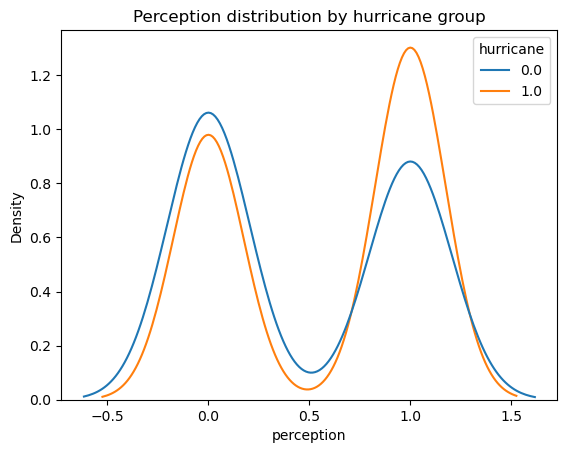

In [14]:
sns.kdeplot(data=df, x='perception', hue='hurricane', common_norm=False)
plt.title("Perception distribution by hurricane group")
plt.show()

In [15]:
def std_diff(x, g):
    m1, m0 = x[g==1].mean(), x[g==0].mean()
    s = np.sqrt((x[g==1].var()+x[g==0].var())/2)
    return (m1-m0)/s

for var in ['perception','age']:
    print(var, std_diff(df[var], df['hurricane']))

perception 0.23501024055658856
age 0.11218466952914045


In [16]:
f = f"{outcomes[0]} ~ perception * hurricane + age + homeownership"
mod = smf.logit(f, data=df).fit(disp=0)
infl = mod.get_influence()
# leverage (hat values) and dfbetas
lever = infl.hat_matrix_diag
dfbetas = infl.dfbetas

print("High leverage obs (top 1%):", np.where(lever > np.quantile(lever, 0.99))[0])

High leverage obs (top 1%): [202 208 233]
